In [1]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer

from torch.utils.data import TensorDataset

import transformers
from transformers import BertForSequenceClassification

import numpy as np
import pandas as pd
import re

In [2]:
df = pd.read_csv('./Corona_NLP_train.csv', encoding='latin-1')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
def extract_hash_tags(s):
    hashes = re.findall(r"#(\w+)", s)
    return " ".join(hashes)
df['hashtags'] = df['OriginalTweet'].apply(lambda x : extract_hash_tags(x))

In [4]:
def extract_mentions(s):
    hashes = re.findall(r"@(\w+)", s)
    return " ".join(hashes)
df['mentions'] = df['OriginalTweet'].apply(lambda x : extract_mentions(x))

In [5]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = df['Sentiment']



encoding = {'Extremely Negative': 0,
            'Negative': 0,
            'Neutral': 1,
            'Positive':2,
            'Extremely Positive': 2
           }

labels = ['Negative', 'Neutral', 'Positive']


y.replace(encoding, inplace=True)

df['encoded_sentiment'] = encoder.fit_transform(y)

In [7]:
df.OriginalTweet.head(5)

0    @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1    advice Talk to your neighbours family to excha...
2    Coronavirus Australia: Woolworths to give elde...
3    My food stock is not the only one which is emp...
4    Me, ready to go at supermarket during the #COV...
Name: OriginalTweet, dtype: object

In [8]:
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split()))

In [9]:
df.OriginalTweet.head(5)

0                                        Gahan and and
1    advice Talk to your neighbours family to excha...
2    Coronavirus Australia Woolworths to give elder...
3    My food stock is not the only one which is emp...
4    Me ready to go at supermarket during the COVID...
Name: OriginalTweet, dtype: object

In [16]:
from sklearn.model_selection import train_test_split

xtrain, xval, ytrain, yval = train_test_split(df['OriginalTweet'], df['encoded_sentiment'], test_size = 0.2)

In [17]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

In [18]:
encoded_data_train = tokenizer.batch_encode_plus(
    xtrain, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=50, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    xval, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=50, 
    return_tensors='pt'
)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/anaconda/envs/py37_default/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [19]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(ytrain.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(yval.values)


# Pytorch TensorDataset Instance
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [37]:
model = transformers.BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [38]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=128)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=128)

In [54]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 1

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [40]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [41]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
device = torch.device('cuda')

In [55]:
model.to(device)

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0].to(device),
                  'attention_mask': batch[1].to(device),
                  'labels':         batch[2].to(device),
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')


Epoch 1
Training loss: 0.3204379112336987



In [43]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [44]:
val_loss, predictions, true_vals = evaluate(dataloader_validation)
val_f1 = f1_score_func(predictions, true_vals)
print('Val Loss = ', val_loss)
print('Val F1 = ', val_f1)

Val Loss =  0.3825511776483976
Val F1 =  0.870216445180939


In [45]:
encoded_classes = encoder.classes_
predicted_category = [encoded_classes[np.argmax(x)] for x in predictions]
true_category = [encoded_classes[x] for x in true_vals]

In [46]:
x = 0
for i in range(len(true_category)):
    if true_category[i] == predicted_category[i]:
        x += 1
        
print('Accuracy Score = ', x / len(true_category))

Accuracy Score =  0.8711127308066083


In [47]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(y_true = true_category, y_pred = predicted_category, labels=list(encoded_classes))

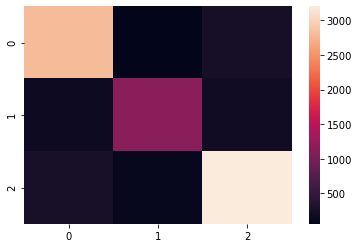

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.DataFrame(confusion_mat, index = list(encoded_classes),columns = list(encoded_classes))
sns.heatmap(df)

# Evaluation

In [49]:
test_df = pd.read_csv('./Corona_NLP_test.csv', encoding='latin-1')

test_df['hashtags'] = test_df['OriginalTweet'].apply(lambda x : extract_hash_tags(x))

test_df['mentions'] = test_df['OriginalTweet'].apply(lambda x : extract_mentions(x))

ytest = test_df['Sentiment']

ytest.replace(encoding, inplace=True)

test_df['encoded_sentiment'] = encoder.fit(ytest)

test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split()))

xtest = test_df.OriginalTweet

encoded_data_test = tokenizer.batch_encode_plus(
    xtest, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=50, 
    return_tensors='pt'
)


input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(ytest.values)


# Pytorch TensorDataset Instance
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

In [50]:
dataloader_testing = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=128)

In [51]:
test_loss, predictions, true_vals = evaluate(dataloader_testing)
test_f1 = f1_score_func(predictions, true_vals)
print('Test Loss = ', test_loss)
print('Test F1 = ', test_f1)

Test Loss =  0.4181562294562658
Test F1 =  0.8562025611432103


In [52]:
encoded_classes = encoder.classes_
predicted_category = [encoded_classes[np.argmax(x)] for x in predictions]
true_category = [encoded_classes[x] for x in true_vals]
x = 0
for i in range(len(true_category)):
    if true_category[i] == predicted_category[i]:
        x += 1
        
print('Accuracy Score = ', x / len(true_category))

Accuracy Score =  0.8570300157977883


In [53]:
np.savetxt("./predictions/bert.csv", predictions, delimiter=",")